# ***Probema de optimización Auto Solar***

El equipo Eolian durante el 2021  y a principios del 2022 se encuentra en proceso de construcción electromotriz del Eolian 6 Áuriga. Esto, con la finalidad de realizar durante el mes de marzo el desafío Eolian de recorrer desde Antofagasta hasta Temuco. 
 
Para la realización del desafío el vehículo debe ser fiable entregando seguridad y comodidad, y debe ser autónomo captando la mayor cantidad de energía posible, gastando la menor cantidad de energía para el movimiento.
 
Una vez se cumplan con estas características, es necesario el desarrollo de la estrategia de control usando la potencia consumida y la potencia de entrada.


El propósito del siguiente cuaderno es el desarrollo y análisis del comando en pista del vehículo solar Eolian Áuriga con la finalidad de recorrer una trayectoria en un tiempo mínimo considerando la dinámica de carga del banco de baterías, la eficiencia solar y la del sistema de tracción con los motores.
 
El objetivo general es el aporte de una herramienta que permita conocer y predecir el manejo de la energía de un vehículo solar en pista.
Los objetivos específicos son el desarrollo de la eceuacion de movimiento del auto, el desarrollo del modelo del banco, el desarrollo del modelo de radiación solar y la validación del modelo con los datos de ruta del desafío.
 
 
Es presentado el desarrollo del modelo en pista de vehículo que incluye el modelo del banco de baterías y la ecuación de movimiento. 
El sistema completo puede describirse por un diagrama de bloques simple.


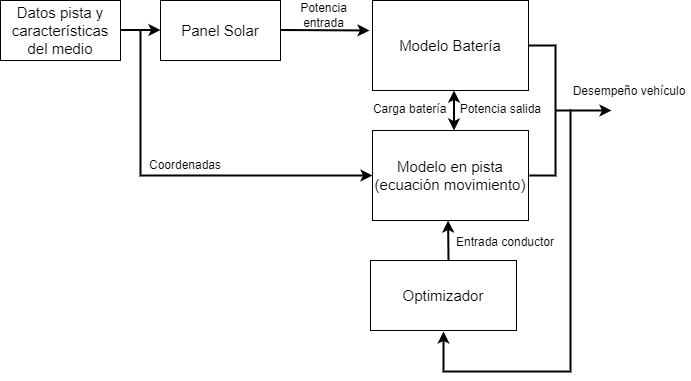

Aquí, las condiciones del clima y de la pista son las entradas principales del sistema. Estos parámetros son las coordenadas de latitud, longitud y altitud y permiten obtener la distancia recorrida, la velocidad y la estimación de la radiación solar.
 
El bloque con el modelo del banco entrega la carga disponible para el desplazamiento del vehículo, mientras que el modelo en pista estima la potencia necesaria para el movimiento.
La potencia entregada por el tren de potencia está asociada a la carga consumida del banco, mientras que la potencia obtenida por los paneles solares entrega energía de entrada.


Para el desarrollo de una estrategia de control debe definirse la función objetivo que se desea minimizar y la variable que permite la acción de control.
 
 
 
El desafío se define con una ruta predefinida entre dos puntos, por lo que la estrategia radica en minimizar el tiempo de recorrido conociendo la distancia.
 
 
 
La variable de control es la velocidad que en el modelo está asociado a un vector de dimensión igual a la partición de la pista realizada para la resolución del problema de control óptimo. Esta segmentación define la tasa de muestreo de la velocidad entregando un valor constante para cierto periodo de tiempo en la pista.
 
 
Con los datos simulados del control óptimo, al momento de realizar el recorrido, el conductor tiene a priori un rango de velocidades para determinados puntos de espacio tiempo.


## Modelo Pista

Modelo dinámico continuo.

\begin{equation}
P_{m} = v \cdot \sum{F}
\end{equation}

\begin{equation}
E_{m} = \frac{P_{m}\cdot t_{secccion}}{\eta_{m}}
\end{equation}


\begin{equation}
\sum F = M\cdot \dot{v} = F_{drag} + F_{frict} + F_{gravity}
\end{equation}

\begin{equation}
\frac{dr}{dt} = v
\end{equation}

\begin{equation}
F_{drag} = \frac{1}{2}\cdot \rho_{air}\cdot A_{frontal}\cdot v^{2}
\end{equation}

\begin{equation}
F_{frict} =M\cdot g\cdot C_{r}\cdot cos(\alpha)
\end{equation}

\begin{equation}
F_{gravity} =M\cdot g\cdot sin(\alpha)
\end{equation}


\begin{equation}
P_{total\,  consumida} = P_{m} + P_{electonica}
\end{equation}

Modelo Banco Baterías continuo.


Discretización

\begin{equation}
\triangle t = \frac{\triangle r}{v}
\end{equation}



\begin{equation}
\triangle r_{k} = r_{k+1} - r_{k}
\end{equation}


\begin{equation}
E_{k+1} = E_{k} + \triangle t \cdot \sqrt{\eta}\cdot (P_{entrada}-P_{salida})
\end{equation}

Problema de control Óptimo

\begin{equation}
\begin{aligned}
\min_{v \in V}  t_{final}(v)  &= \sum_{k=1}^{n-1} \triangle t_{k}  = \sum_{k=1}^{n-1}\frac{\triangle r_{k}}{v} \\
\text{s.a. } 0<v&<v_{maxima} \\
 -P_{regeneracion}<P&<P_{maxima} \\
  0<E_{b}&<E_{maxima} \\
v\in V               &= \{v_1, ..., v_{n}\}.
\end{aligned}
\end{equation}

1� = 111 km 

## Implementación

### Librerías

In [65]:
# Librerias

import datetime
import time
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import copy
from scipy.optimize import minimize
import numpy as np


In [66]:
94 * 230

21620

In [67]:
#  Datos de optimizacion
optimizacion = {"v0": 15,
                "vmax": 22,
                "lar_sec_max": 2e4,
                "camb_pend_max": 0.15}
# Bateria
bat = {"carga_bat":  round(3.7 * 28 * 3.3 * 72) * 3600, #21620 * 3600, #
       "eff_bat": 1}  #

# Solar
solar = {"nubosidad": 10,
         "cte_solar": 1360,  # arana
         "Pa_normal": 101325,  # normal
         "A_panel": 3.5,
         "tau": 0.7}  # trasnitividad arana

vehiculo = {"g": 9.81,
            "rho_A": 1.3,
            "Kr": 1.87e-2,
            "A_frontal": 1.5,
            "Cr": 1.7e-3,
            "pot_electronica": 119,
            "m": 700,
            "eff_entrada": 0.0,
            "eff_salida": 0.7}
# Horario y cronograma
# Fecha de inicio
FECHA_INICIO = datetime.date.today()  # +  datetime.timedelta(days=1)
# Horas, minutos y segundos de inicio, el WSC es de 8AM a 17 PM
HORA_INICIO = datetime.time(8, 30 ,0)  #datetime.time(8, 30, 0)
# año, mes, dia, hora, min, seg
FECHA_HORA_INICIO = datetime.datetime.combine(FECHA_INICIO, HORA_INICIO)
# Rango de tiempo de conducción
RANGO_VELOCIDAD_CONDUCCION = [8, 17]


## Proprocesaminto de columnas de datos de entrada


In [68]:
def preprocesamiento_columnas_datos(filename):
    """
    Funcion de preprocesamient de los datos que tiene el Áuriga
    en su repositorio. Eli,ina las columnas no utilizadas y
    cambia el separador de , a ;.
    Input :
    =======
    filename : [.csv], archivo csv
    Output :
    =======
    filename :[.csv], archivo csv
    """
    df = pd.read_csv(filename, sep=",")
    if "Unnamed: 0" in df:
        df.drop("Unnamed: 0", inplace=True, axis=1)
    if "color" in df:
        df.drop("color", inplace=True, axis=1)
    if "width" in df:
        df.drop("width", inplace=True, axis=1)
    if "opacity" in df:
        df.drop("opacity", inplace=True, axis=1)
    if "name" in df:
        df.drop("name", inplace=True, axis=1)
    if "desc" in df:
        df.drop("desc", inplace=True, axis=1)
    if "slope (%)" in df:
        df.drop("slope (%)", inplace=True, axis=1)
    if "distance_interval (m)" in df:
        df.drop("distance_interval (m)", inplace=True, axis=1)
    if "type" in df:
        df.drop("type", inplace=True, axis=1)
    if "scale" in df:
        df.drop("scale", inplace=True, axis=1)
    if "sym" in df:
        df.drop("sym", inplace=True, axis=1)
    if "time" in df:
        df.drop("time", inplace=True, axis=1)
    if "activity" in df:
        df.drop("activity", inplace=True, axis=1)
    if "course" in df:
        df.drop("course", inplace=True, axis=1)
    if "speed (km/h)" in df:
        df.drop("speed (km/h)", inplace=True, axis=1)
    df = df.astype(float).round(4)
    # df['altitude (m)'] = 1000
    # df['longitude'] = 0
    
    df.astype({"latitude": float, "longitude": float})
    # df = df[3400:3500]
    # Guardar en csv
    df.to_csv(str(filename)+"prepos"+".csv", sep=";", encoding="utf-8",
              index=False)


def n2rad(x):
    """
    grado a radianes
    """
    return (np.pi / 180) * x


def distancia(pnt_partida, pnt_final):
    """
    Funcion obtencion de norma ecuclediana
    """
    dx = pnt_final[0] - pnt_partida[0]
    dy = pnt_final[1] - pnt_partida[1]
    return np.sqrt(dx ** 2 + dy ** 2)


def angulo_elevacion(pnt_partida, pnt_final):
    """
    Funcion obtencion de angulo de elevacion
    """
    dx = pnt_final[0] - pnt_partida[0]
    dy = pnt_final[1] - pnt_partida[1]
    dz = pnt_final[2] - pnt_partida[2]
    return np.arctan(dz / np.sqrt(dx ** 2 + dy ** 2))


def grad2m(grad):
    """
    grados a metros
    """
    return grad * 111.139 * 1000


def m2grad(m):
    """
    metros a grados
    """
    return m / 111.139 / 1000


def J2Kwh(nivel_energia):
    """
    metros a grados
    """
    return nivel_energia * (1 / (3600 * 1000))


def ms2KmHrs(velocidad):
    """
    metros a grados
    """
    return velocidad * 3.6


def Js2Kw(nivel_energia):
    """
    J/seg to Kw
    """
    return nivel_energia


def despliegue_solucion(velocidades_optimas, titulo="Velocidad óptima"):
    """
    Despliegue de la velocidad óptima
    """
    velocidades = list(velocidades_optimas[:])
    velocidades.append(velocidades[-1])
    plt.step(range(len(velocidades)), list(map(ms2KmHrs, velocidades)),
             where="post", linewidth=3.0, linestyle="-.")
    plt.grid()
    plt.title(titulo)
    plt.xlabel("Sección")
    plt.ylabel("Velocidad [Km/hrs]")
    figure = plt.gcf()
    figure.set_size_inches(12, 12)
    plt.tight_layout()
    plt.savefig("Datos/Optimal speed "
                + str(datetime.datetime.today().strftime("%Y-%m-%d %H-%M-%S"))
                + ".png")
    plt.show()


def despliegue_relacion_velocidad_radiacion_solar(velocidades_optimas,
                                                  nivel_radiacion_solar):
    """
    Funcion
    """
    velocidades = list(velocidades_optimas[:])
    velocidades.append(velocidades[-1])
    plt.subplot(2, 1, 1)
    plt.title("Velocidad óptima")  # "Velocidad óptima
    plt.xlabel("Sección")
    plt.ylabel("Velocidad [Km/hrs]")  # Velocidad (m / s)
    plt.step(range(len(velocidades)), list(map(ms2KmHrs, velocidades)),
             where="post")
    plt.plot(range(len(velocidades_optimas)),
             list(map(ms2KmHrs, velocidades_optimas)), linewidth=2.0,
             linestyle="-.")
    plt.grid()
    plt.subplot(2, 1, 2)
    plt.title("Radiación solar")  # Radiación solar
    plt.xlabel("Sección")  #
    plt.ylabel("Nivel radiacion Solar [w/m^2]")  # Radiación solar W / m32
    plt.plot(range(len(velocidades_optimas)), nivel_radiacion_solar,
             linewidth=2.0, linestyle="-.")
    plt.grid()
    figure = plt.gcf()
    figure.set_size_inches(12, 12)
    plt.tight_layout()
    plt.savefig("Datos/Speed and solar radiation relationship "
                + str(datetime.datetime.today().strftime("%Y-%m-%d %H-%M-%S"))
                + ".png")
    plt.show()


## Parámetros


## Datos solares del ambiente

In [69]:
def mod_radiacion_solar(lat, datetime):
    """
    Funcion para calculo de radciaon solar al modelo
    """
    dia_del_ano = datetime.timetuple().tm_yday
    # Obtencion de la hora
    hr = datetime.hour
    # restriccion sobre radiacion solar
    lat_rad = n2rad(lat)
    # Formula declinacion solar
    dlt_SD = n2rad(23.45 * np.sin(n2rad(360 * (284 + dia_del_ano) / 365)))
    # Hotra estandar y de medio dia
    hr_angl = n2rad(15 * (hr - 12))  # angulo horario en min
    # Variacion geografica y temporal del cenit
    cos_ph_sin = np.sin(lat_rad) * np.sin(dlt_SD)
    cos_phi_cos = np.cos(lat_rad) * np.cos(dlt_SD) * np.cos(hr_angl)
    cos_phi = cos_ph_sin + cos_phi_cos
    # numero optico de masa en funcion de la presion atmosferica
    m = solar["Pa_normal"] / (0.1013 * cos_phi)  # optical airmass
    # radiacion solar directa
    rad_dir = cos_phi * solar["cte_solar"] * (solar["tau"] ** m)
    # radiacion silar difusa
    rad_dif = 0.3 * (1.0 - (solar["tau"] ** m)) * solar["cte_solar"] * cos_phi
    # radiacion total
    rad_total = rad_dir + rad_dif
    rad_solar = rad_total * (1 - solar["nubosidad"] / 100)
    return rad_solar


Multiply the degrees of separation of longitude and latitude by 111,139 to get the corresponding linear distances in meters.R_{s}



## Simulación en pista

In [70]:
class Pista:
    """
    Clase para pista de carreras.
    Consiste en un conjunto de puntos con coordenadas (x, y, z) y
    sus características (radiación solar, distancia al anterior)
    """
    def __init__(self, largo_seccion_max=optimizacion["lar_sec_max"],
                 cambio_pendiente_max=optimizacion["camb_pend_max"]):
        """
        Constructor de clase pista de carreras
        inicializa con e largo maximo de la seccion
        y con el angulo maximo de seccion
        """
        # largo de seccion
        self.largo_seccion_max = largo_seccion_max
        # maximo angulo de elevacion
        self.cambio_pendiente_max = cambio_pendiente_max
    # creacion de dataframe con caracteristicas de cada punto
    seccion = pd.DataFrame(columns=["largo",
                                    "largo_sum",
                                    "angulo_elevacion",
                                    "coord",
                                    "radiacion_solar",
                                    "tiempo_llegada"])

    def cargar_pista_csv(self, filename):
        """
        Funcion lectura de variables
        Requiere de la data preprocesada
        """
        pista = pd.read_csv(filename, sep=";")
        # Se toma hasta la distancia
        pista = pista.iloc[:, 0:3] #3
        # las coordenadas es la latitud, la longitud y la elevacion
        self.seccion.coord = [[pista.iloc[i, 0],
                               pista.iloc[i, 1],
                               pista.iloc[i, 2]] for i in range(len(pista))]
        print("Cargando {} puntos".format(len(self.seccion)))

    def preprocesar_pista(self):
        """
        Funcion de preprocesamiento de los datos de entrada
        """
        # transformar metor la latitur, la longitud y se deja la elevaion igual
        self.seccion.coord = self.seccion.coord.apply(
            lambda coords: [grad2m(coords[0]), grad2m(coords[1]), coords[2]])
        # calculo de largo entre puntos y la suma
        largo_sum = 0.0
        for i in range(len(self.seccion) - 1):
            largo = distancia(
                self.seccion.iloc[i].coord,
                self.seccion.iloc[i + 1].coord
            )
            largo_sum += largo
            self.seccion.iloc[i].largo = largo
            self.seccion.iloc[i].largo_sum = largo_sum
        # calculo de angulo de elevacion en cada punto
        for i in range(len(self.seccion) - 1):
            self.seccion.iloc[i].angulo_elevacion = angulo_elevacion(
                self.seccion.iloc[i].coord,
                self.seccion.iloc[i + 1].coord
            )
        # tranformar a grados nuevamente
        self.seccion.coord = self.seccion.coord.apply(
            lambda coords: [m2grad(coords[0]), m2grad(coords[1]), coords[2]])

    def combinar_pts_2_seccion(self, show_info=False):
        """
        Funcion de lectura DVT de variables TPDO en formato csv
        para modelo del proceso
        """
        self.seccion.coord = self.seccion.coord.apply(
            lambda coords: [grad2m(coords[0]), grad2m(coords[1]), coords[2]])
        print("Antes de combinar {} puntos".format(len(self.seccion)))
        new_seccion = pd.DataFrame(columns=["largo",
                                            "largo_sum",
                                            "angulo_elevacion",
                                            "coord",
                                            "radiacion_solar",
                                            "tiempo_llegada"])
        # Iniciaizacionde la primera seccion
        section_start = self.seccion.iloc[0].coord  # seccion inicial
        section_end = self.seccion.iloc[1].coord  # seccion final
        section_dist = distancia(section_start, section_end)
        #
        for i in range(2, len(self.seccion)):
            if show_info:
                print("\n", i)
            cur_point = self.seccion.iloc[i].coord  # puntos actuale
            # calculo de angulo elevacion previo
            previous_slope_angle = angulo_elevacion(section_start, section_end)
            # calculo de siguiente elevacion
            cur_slope_angle = angulo_elevacion(section_end, cur_point)
            # delta angulo de elevacion
            slp_ang_dif = abs(previous_slope_angle - cur_slope_angle)
            dist = distancia(section_end, cur_point)  # distancia siguiente
            if show_info:
                print("Dif áng {}, dist {}, sum dist {}".format(slp_ang_dif,
                                                                dist,
                                                                section_dist + dist))
            def add_new_section():
                """
                Adicion de seccion y combinacion
                """
                if len(new_seccion) == 0:
                    section_dist_sum = 0 + section_dist
                else:
                    section_dist_sum = new_seccion.loc[len(new_seccion) - 1].largo_sum + section_dist
                x = m2grad(section_start[0])
                y = m2grad(section_start[1])
                z = section_start[2]
                # coordinates = list(map(m2deg, section_start))  # make more clear de2m and reverse translations
                new_seccion.loc[len(new_seccion)] = ([section_dist,
                                                      section_dist_sum,
                                                      previous_slope_angle, 
                                                      [x, y, z], None, None])
            if slp_ang_dif < self.cambio_pendiente_max and section_dist + dist < self.largo_seccion_max:
                if show_info:
                    print("Decisión: combinar")
                section_dist += dist
                section_end = cur_point
            else:
                if show_info:
                    print("Decisión: separar")
                add_new_section()
                # Prepare for next section
                section_start = section_end
                section_end = cur_point
                section_dist = dist
            if i == len(self.seccion) - 1:  # Separating last point
                if show_info:
                    print("Separar la ultima sección")
                add_new_section()
        self.seccion = new_seccion
        print("Después de combinar {} secciones".format(len(self.seccion)))

    def tiempo_llegada(self, fecha_hora_inicio, rango_velocidad_conduccion,
                       velocidades):  
        """
        Calcula el tiempo en que el coche solar llegará a cada sección.
        Computes time when solar car will arrive to each section
        """
        datetime_cur = copy.deepcopy(fecha_hora_inicio)
        for i in range(len(self.seccion)):
            self.seccion.at[i, "tiempo_llegada"] = datetime_cur
            seconds = self.seccion.iloc[i].largo / velocidades[i]
            datetime_cur += datetime.timedelta(seconds=seconds)
            if datetime_cur.hour >= rango_velocidad_conduccion[1]:
                seconds_exceeded = (datetime_cur.hour - rango_velocidad_conduccion[1]) * 3600 + datetime_cur.minute * 60 + datetime_cur.second
                datetime_cur += datetime.timedelta(days=1)
                datetime_cur = datetime_cur.replace(hour=rango_velocidad_conduccion[0], minute=0, second=0)
                datetime_cur += datetime.timedelta(seconds=seconds_exceeded)

    def calcular_parametros_clima_puro(self):
        """
        Calculo de radiacion solar en cada instante
        """
        # se itera en cada seccion
        for i in range(len(self.seccion)):
            # obetencion de latitud y longitud en cada instante
            latitud, longitud = self.seccion.iloc[i].coord[0], self.seccion.iloc[i].coord[1]
            # obetencion de tiempo actual
            datetime_cur = self.seccion.iloc[i].tiempo_llegada
            # calclo de radiacion solar
            self.seccion.at[i, "radiacion_solar"] = mod_radiacion_solar(latitud, datetime_cur)

    def despliegue_altitud_pista(self, titulo="Tabla de elevación de rutas"):
        """
        Despliegue de altitud en km
        """
        # obetencion de suma de distancias recrrifas
        distancia_cubierta = self.seccion.largo_sum / 1000  # en km
        # obetencion de altidud del vector de caracteristicas
        altitudes = [coord[2] for coord in self.seccion.coord]
        plt.xlabel("Distancia recorrida [Km]")
        plt.ylabel("Altura [m]")
        plt.title(titulo)
        plt.grid()
        figure = plt.gcf()
        figure.set_size_inches(12, 12)
        plt.tight_layout()
        plt.plot(distancia_cubierta, altitudes)
        plt.savefig("Datos/" + titulo + " "
                    + str(datetime.datetime.today().strftime("%Y-%m-%d %H-%M-%S"))
                    + ".png")
        plt.show()

    def despliegue_caractersiticas_pista(self, titulo=None):
        """
        Despliegue de caracateristicas en cada punto
        """
        # inicializacion de listas para caractericticas de lada pto-coordenada
        distancia_cubierta = []
        altitudes = []
        angulo_elevacion = []
        radiacion_solar = []
        tiempo_llegada = []
        # guardar en una lista
        for index, section in self.seccion.iterrows():
            distancia_cubierta.append(section.largo_sum / 1000)  # en km
            altitudes.append(section.coord[2])
            angulo_elevacion.append(section.angulo_elevacion)
            radiacion_solar.append(section.radiacion_solar)
            tiempo_llegada.append(section.tiempo_llegada)
        titulos = ["Altura", "Ángulos de inclinación", "Radiación solar",
                   "Hora de llegada"]
        ylables = ["Altura [m]", "Ángulo de inclinación [radianes]",
                   "Radiación solar [W / m ^ 2]", "Hora de llegada"]
        y = [altitudes, angulo_elevacion, radiacion_solar, tiempo_llegada]
        fig, axs = plt.subplots(1, 4, figsize=(23, 6))
        for i in range(len(titulos)):
            axs[i].grid(True)
            axs[i].set_xlabel("Distancia recorrida [Km]")
            # Distancia recorrida (km)
            axs[i].set_ylabel(ylables[i])
            axs[i].set_title(titulos[i])
            axs[i].plot(distancia_cubierta, y[i], "b*-")
        if titulo is not None:
            fig.suptitle(titulo)
        fig.tight_layout()
        plt.savefig("Datos/track_features "
                    + str(datetime.datetime.today().strftime("%Y-%m-%d %H-%M-%S"))
                    + ".png")        
        plt.show()






## Administrador de Energía

In [71]:
def energia_porcentaje(nivel_energia):
    """
    nivel de energia en porcentaje
    """
    return (nivel_energia / bat["carga_bat"]) * 100


def mod_energia_entrada(v_k,
                        rad_solar,
                        A_panel,
                        theta_r,
                        delta_r,
                        eff_entrada):
    """
    Calculo de energia de enetrada solar
    """
    p_sun = rad_solar * A_panel * eff_entrada * np.cos(theta_r)
    # instante de tiempo
    t = delta_r / v_k
    # calculo de energia en Joules
    e_in = p_sun * t
    # energy_income = p_real
    return e_in


def mod_energia_salida(v_k,
                       delta_r,
                       rho_A,
                       A_frontal,
                       Cr,
                       m,
                       g,
                       theta_r,
                       Kr,
                       pot_electronica,
                       eff_salida):
    """
    Calculo de potencia de salida
    """
    # fuersa aerodinamica
    fza_aero_c = fza_aero(rho_A,
                          v_k,
                          A_frontal,
                          Cr)
    # fuerza de gravedad
    fza_grav_c = fza_grav(m,
                          g,
                          theta_r)
    # fuerza friccion
    fza_res_c = fza_fricc(m,
                          g,
                          theta_r,
                          Kr)
    # fuerza total
    fza_tot = fza_aero_c + fza_grav_c + fza_res_c
    if fza_tot < 0:
        return None
    # tiempo
    delta_t = delta_r / v_k
    # calculo de trabajo para el movimiento
    w_traccion = (fza_tot * delta_r) / eff_salida
    # calculo de potencia electronica a energia
    w_electronica = pot_electronica * delta_t
    # energia de salida total
    e_salida = w_traccion + w_electronica
    # return energy_outcome / section_time
    return e_salida


def mod_pot_salida(v_k,
                   delta_r,
                   rho_A,
                   A_frontal,
                   Cr,
                   m,
                   g,
                   theta_r,
                   Kr,
                   potencia_electronica,
                   eff_salida):
    """
    Calculo de potencia de salida
    """ 
    # fuersa aerodinamica
    fza_aero_c = fza_aero(rho_A,
                          v_k,
                          A_frontal,
                          Cr)
    # fuerza de gravedad
    fza_grav_c = fza_grav(m,
                          g,
                          theta_r)
    # fuerza friccion
    fza_res_c = fza_fricc(m,
                          g,
                          theta_r,
                          Kr)
    # fuerza total
    fza_tot = fza_aero_c + fza_grav_c + fza_res_c
    if fza_tot < 0:
        return None
    # P = fza_tot * v_k
    # if P > 4000:
    #   return 4000
    # else:
    #   return P
    # tiempo
    # section_time = largo_seccion / seccion_velocidad
    # calculo de trabajo para el movimiento
    # work_motion = (fuerza_total * largo_seccion) / eficiencia_salida
    # energia_salida = fuerza_total #+ work_equipment
    # return energy_outcome / section_time
    return fza_tot * 0.3

def p_out_motores(v_k,
                 delta_r,
                 e_salida,
                 eff):
    """
    calculo de fuerza aerodinamica
    """
    delta_t = delta_r / v_k
    # largo_seccion / v_k
    pout_motores = (eff * (e_salida - 80)) / delta_t
    # pout_motores = (e_salida) / delta_t
    if pout_motores < 0:
        return 0
    return pout_motores

def p_in_motores(v_k,
                 delta_r,
                 e_salida,
                 eff):
    """
    calculo de fuerza aerodinamica
    """
    delta_t = delta_r / v_k
    # largo_seccion / v_k
    # pin_motores = (eff * e_salida) / delta_t
    pin_motores = (e_salida) / delta_t
    if pin_motores < 0:
        return 0
    return pin_motores


def fza_aero(rho_A,
             v_k,
             A_f,
             Cr):
    """
    calculo de fuerza aerodinamica
    """
    return (1 / 2) * rho_A * (v_k ** 2) * A_f * Cr


def fza_grav(m,
             g,
             theta_r):
    """
    calculo de fuerza gravedad
    """
    return m * g * np.sin(theta_r)


def fza_fricc(m,
              g,
              theta_r,
              Kr):
    """
    calculo de fuerza resistiva
    """
    return m * g * Kr * np.cos(theta_r)


def calcular_niveles_energia(pista: Pista,
                             vector_velocidad: list):
    """
    Computes energy level of each sector
    Calcular los niveler de energia total de cada sector
    """
    # inicializacion de nivel de energia del banco de baterias
    niveles_energia = [bat["carga_bat"]]
    # itererar en cada seccion y calcular el energia de entrada y salida
    for i in range(len(pista.seccion)):
        # Calculo de energia de entrada solar
        energia_entrada = mod_energia_entrada(vector_velocidad[i],
                                              pista.seccion.loc[i].radiacion_solar,
                                              solar["A_panel"],
                                              pista.seccion.loc[i].angulo_elevacion,
                                              pista.seccion.loc[i].largo,
                                              vehiculo["eff_entrada"])
        # Calculo de energia de salida
        energia_salida = mod_energia_salida(vector_velocidad[i],
                                            pista.seccion.loc[i].largo,
                                            vehiculo["rho_A"],
                                            vehiculo["A_frontal"],
                                            vehiculo["Cr"],  # frontal_resistance_rate
                                            vehiculo["m"],
                                            vehiculo["g"],
                                            pista.seccion.loc[i].angulo_elevacion,
                                            vehiculo["Kr"],
                                            vehiculo["pot_electronica"],
                                            vehiculo["eff_salida"])
        if energia_salida is None:
            energia_salida = 0
        # euler para dinamica energia bateria
        nivel_energia = niveles_energia[-1] + (energia_entrada - energia_salida) * bat["eff_bat"]
        niveles_energia.append(nivel_energia)
    # entrega lista con variacion de la energia
    return niveles_energia


def calcular_niveles_energia_full(pista: Pista,
                                  vector_velocidad: list):
    """
    Caclula y enetrega la energia de enetrada-salida y 
    la aenergia total del sistema
    """
    # Incializacion de listas para energias
    niveles_energia = [bat["carga_bat"]]
    energia_entradas = [0]
    energia_salidas = [0]
    pot_salidas = [0]
    pot_entradas = [0]
    # Vector de caracteristicas del proceso y paramteros
    parametros_modelo = pd.DataFrame(columns=["radiacion_solar",
                                              "area_panel",
                                              "section_slope_angle",
                                              "largo_seccion",
                                              "eficiencia_entrada",
                                              "energia_entrada",
                                              "rho_A",
                                              "area_frontal_auto",
                                              "Cr",  # frontal_resistance_rateCr
                                              "masa_auto",
                                              "g",
                                              "Kr",  # Kr
                                              "potencia_electronica",
                                              "eficiencia_salida",
                                              "energia_salida",
                                              "coord",
                                              "seccion_velocidad",
                                              "tiempo_llegada",
                                              "distancia_cubierta"])
    # iterar y calculo de nergia e entrada y salida
    for i in range(len(pista.seccion)):
        #
        energia_entrada = mod_energia_entrada(vector_velocidad[i],
                                              pista.seccion.loc[i].radiacion_solar,
                                              solar["A_panel"],
                                              pista.seccion.loc[i].angulo_elevacion,
                                              pista.seccion.loc[i].largo,
                                              vehiculo["eff_entrada"])
        energia_entradas.append(energia_entrada)
        #
        energia_salida = mod_energia_salida(vector_velocidad[i],
                                            pista.seccion.loc[i].largo,
                                            vehiculo["rho_A"],
                                            vehiculo["A_frontal"],
                                            vehiculo["Cr"],
                                            vehiculo["m"],
                                            vehiculo["g"],
                                            pista.seccion.loc[i].angulo_elevacion,
                                            vehiculo["Kr"],
                                            vehiculo["pot_electronica"],
                                            vehiculo["eff_salida"])
        if energia_salida is None:
            print("La energía de resultado fue negativa en la sección:", i)
            energia_salida = 0
        energia_salidas.append(energia_salida)
        nivel_energia = niveles_energia[-1] + (energia_entrada - energia_salida) * bat["eff_bat"]
        niveles_energia.append(nivel_energia)
        #
        pot_entrada = p_in_motores(vector_velocidad[i],
                                   pista.seccion.loc[i].largo,
                                   energia_entrada, vehiculo["eff_entrada"])
        pot_entradas.append(pot_entrada)
        #
        pot_salida = p_out_motores(vector_velocidad[i],
                                  pista.seccion.loc[i].largo,
                                  energia_salida, vehiculo["eff_salida"])
        pot_salidas.append(pot_salida)
        #
        # pot_salida = mod_pot_salida(vector_velocidad[i],
        #                             pista.seccion.loc[i].largo,
        #                             vehiculo['rho_A'],
        #                             vehiculo['A_frontal'],
        #                             vehiculo['Cr'],
        #                             vehiculo['m'],
        #                             vehiculo['g'],
        #                             pista.seccion.loc[i].angulo_elevacion,
        #                             vehiculo['Kr'],
        #                             vehiculo['pot_electronica'],
        #                             vehiculo['eff_salida'])
        # pot_salidas.append(pot_salida)
        #
        parametros_modelo.loc[len(parametros_modelo)] = [pista.seccion.loc[i].radiacion_solar,
                                                         solar["A_panel"],
                                                         pista.seccion.loc[i].angulo_elevacion,
                                                         pista.seccion.loc[i].largo,
                                                         vehiculo["eff_entrada"],
                                                         energia_entrada,
                                                         vehiculo["rho_A"],
                                                         vehiculo["A_frontal"],
                                                         vehiculo["Cr"],
                                                         vehiculo["m"],
                                                         vehiculo["g"],
                                                         vehiculo["Kr"],  # Kr
                                                         vehiculo["pot_electronica"],
                                                         vehiculo["eff_salida"],
                                                         energia_salida,
                                                         pista.seccion.loc[i].coord,
                                                         vector_velocidad[i],
                                                         pista.seccion.loc[i].tiempo_llegada,
                                                         pista.seccion.loc[i].largo_sum]
    # enetrega la energia de entrada, salida, total y
    return {"niveles": niveles_energia,
            "entradas": energia_entradas,
            "salidas": energia_salidas,
            "pot_salida": pot_salidas,
            "pot_entrada": pot_entradas,
            "parametros": parametros_modelo}

def despliegue_niveles_energia(niveles_energia: list,
                               energia_entradas: list,
                               energia_salidas: list,
                               pot_salidas: list,
                               pot_entradas: list):
    """
    desplegue de energia de enetrda y salida y descarga de la bateria
    """
    plt.figure(1)
    plt.title("Descarga energía")
    plt.xlabel("Sección")  # "Numero de sección
    plt.ylabel("Cantidad de energía [kWh]")  # Cantidad de energía (J)
    plt.plot(range(len(niveles_energia)), list(map(J2Kwh, niveles_energia)), "b",
             label="Carga de la batería [kWh]", linewidth=3.0)  # Bateria cargada
    plt.grid(True)
    plt.legend()
    figure = plt.gcf()
    figure.set_size_inches(12, 12)
    plt.legend()
    figure = plt.gcf()
    figure.set_size_inches(12, 12)
    plt.savefig("Datos/Carga banco"
                + str(datetime.datetime.today().strftime("%Y-%m-%d %H-%M-%S"))
                + ".png")    
    plt.show()

    plt.figure(2)
    plt.title("Potencias entrada salida")
    plt.xlabel("Sección")  # "Numero de sección
    plt.ylabel("Cantidad de energía [kWh]")  # Cantidad de energía (J)
    # Reposición de energía
    plt.plot(range(len(energia_entradas)), list(map(J2Kwh, energia_entradas)),
             "b*-", label="Reposición de energía [kWh]", linewidth=2.0)
    # np.linspace()
    # plt.plot(range(len(energia_entradas)), list(map(J2Kwh, energia_entradas)))
    # Consumo de energía
    plt.plot(range(len(energia_salidas)), list(map(J2Kwh, energia_salidas)),
             "r*-", label="Consumo de energía [kWh]", linewidth=2.0)
    plt.grid(True)
    plt.legend()
    figure = plt.gcf()
    figure.set_size_inches(12, 12)
    plt.tight_layout()
    plt.legend()
    figure = plt.gcf()
    figure.set_size_inches(12, 12)
    plt.savefig("Datos/Carga entrada-salida"
                + str(datetime.datetime.today().strftime("%Y-%m-%d %H-%M-%S"))
                + ".png")    
    plt.show()
    # plt.figure(3)
    # plt.title("")
    # plt.xlabel("Número de sección")  # "Numero de sección
    # plt.ylabel("Cantidad de energía Kw")  # Cantidad de energía (J)
    # # Reposición de J/s
    # plt.plot(range(len(pot_entradas)), list(map(Js2Kw, pot_salidas)),
    #          "r*-", label='Potencia salida ', linewidth=2.0)
    # plt.plot(range(len(pot_entradas)), list(map(Js2Kw, pot_entradas)),
    #          "b*-", label='Potencia entrada ', linewidth=2.0)
    # plt.grid(True)
    # plt.legend()
    # figure = plt.gcf()
    # figure.set_size_inches(12, 12)
    # plt.tight_layout()
    # plt.legend()
    # figure = plt.gcf()
    # figure.set_size_inches(12, 12)
    plt.show()
# time.time()

# Nueva sección

    x_linea = x_sample[indx_inf:indx_sup]  # Longitud de onda
    y_linea = y_sample[indx_inf:indx_sup]  # Flujo de radiacin
    # Condicion inicial para fit de recta simple
    params0_linea = 0.1e-1, 0.1e-1
    # Ajuste de non linear least sqaures para ajustar una curva
    a_linea, a_cov_linea = curve_fit(modelo_linea, x_linea,
                                     y_linea, params0_linea)
    # Estimacion del Error de medicion entre dato modelo y dato real
    err_linea = y_linea - modelo_linea(x_linea, a_linea[0],  a_linea[1])

## Método de Optimización

In [72]:
def penalizacion_velocidad(velocidades: list):
    """
    Penaliza los valores de velocidad superiores a MAX_SPEED y menos de 0
    """
    # funcion de penalizacion con funcion predefinida
    func_penalizacion = bloque_funcion_penalizacion(0, optimizacion["vmax"])
    # entrega la sumatoria de penalizacion de la velocidad
    return sum([func_penalizacion(x) for x in velocidades])


def penalizacion_niveles_energia(niveles_energia: list):
    """
    Penaliza los valores de nivel de energía más de 100 y menos de 0
    """
    funcion_penalizacion = bloque_funcion_penalizacion(0, 100)
    energy_levels_in_percents = list(map(energia_porcentaje, niveles_energia))
    # Starting from 1 due to full charge of battery at beginning of race
    return sum([funcion_penalizacion(x) for x in energy_levels_in_percents[1:]])


def bloque_funcion_penalizacion(a, b):
    """
    Creates penalty function for box constraints: a < x < b
    Crea una función de penalización para las restricciones de caja: a <x <b
    """
    def inner(x, deg=2):
        return np.piecewise(x, [x < a, x > b], [lambda x: (a - x) ** deg,
                                                lambda x: (x - b) ** deg])
        
    # def inner(x, koef=1, deg=30):
    #         width = b - a
    #         shift = a / (width / 2) + 1
    #         return koef * (1 / (width / 2) * x - shift) ** deg
    return inner


def calcular_funcion_perdida(vector_velocidad: list,
                             pista: Pista):
    """
    Calcula la función de pérdida de acuerdo con los niveles de energía
    y las velocidades de sección.
    """
    # Sumatoria del tiempo en cada seccion tiempo = larg/velocidad
    return sum([pista.seccion.loc[i].largo / vector_velocidad[i] for i in range(len(pista.seccion))])


def calcular_penalizacion_total(vector_velocidad: list,
                                pista: Pista):
    """
    Calcula la penalización total según los niveles
     de energía y las velocidades de sección.
    """
    # calculo de la energia del banco
    niveles_energia = calcular_niveles_energia(pista, vector_velocidad)
    # penalizacion de la energia
    penalizacion_nivel_energia = penalizacion_niveles_energia(niveles_energia)
    # penalizacion de la velcoidad
    pen_velocidad = penalizacion_velocidad(vector_velocidad)
    # penalizacion total
    penalizacion_total = penalizacion_nivel_energia + pen_velocidad
    return penalizacion_total


def metodo_penalizacion(func,
                        funcion_penalizacion,
                        x0,
                        args=None,
                        eps=1,
                        tol=1e-3,
                        mu0=1,
                        betta=3,
                        max_step=20,
                        show_info=False):
    """
    Minimiza la función con restricciones utilizando el método
    de penalización exterior
    """
    # inicializaccion de dataframe con descripscion de la optimizacion
    optimization_description = pd.DataFrame(columns=["Step",
                                                     "MU",
                                                     "Función Pérdida",
                                                     "Función Penalización",
                                                     "MU * Función Penalización",
                                                     "Average speed",
                                                     "Speed vector norm",
                                                     "Speed vector change norm"])
    # parametros metodo de penalizacion
    x = x0
    mu = mu0
    step = 1
    if show_info:
        print("Starting minimization")
    while True:
        if show_info:
            print("Step:", step, "mu:", mu)

        def func_to_minimize(vector_velocidad: list, pista: Pista):
            """
            Inicializacion de funcion a minimizar
            """
            return func(vector_velocidad, pista) + mu * funcion_penalizacion(vector_velocidad, pista)
        if show_info:
            print("Starting internal minimization")
        # minimizacion
        new_x, success = minimize_unconstrained(func=func_to_minimize,
                                                x0=x,
                                                args=args,
                                                method="L-BFGS-B",
                                                tol=tol,
                                                show_info=show_info)
        # Calculo de tiempo de llegada
        args.tiempo_llegada(FECHA_HORA_INICIO, RANGO_VELOCIDAD_CONDUCCION, new_x)
        # calculo de radciacion solar con modelo
        args.calcular_parametros_clima_puro()
        # calculo de la funcion de perdidas con la funcion a minimizar
        valor_funcion_perdida = func(new_x, args)
        # calculo de penalizacion
        valor_funcion_penalizacion = funcion_penalizacion(new_x, args)
        # ponderacion por mu del metdodo de optimizacion
        mu_x_valor_funcion_penalizacion = mu * funcion_penalizacion(new_x, args)
        # calculo de vector de velocidad promedio
        average_speed = sum([new_x[i] * args.seccion.loc[i].largo for i in range(len(new_x))]) / sum(args.seccion.largo)
        # normalizacion del promedop de velcidades
        speed_vector_norm = np.linalg.norm(new_x, 1)
        # calculo de cambio de la norma
        speed_vector_change_norm = np.linalg.norm(new_x - x, 1)
        # guardado de valores optimizacion obtenidos
        optimization_description.loc[len(optimization_description)] = (int(step), mu,
                                                                       round(valor_funcion_perdida, 3),
                                                                       round(valor_funcion_penalizacion, 3),
                                                                       round(mu_x_valor_funcion_penalizacion, 3),
                                                                       np.round(average_speed, 3),
                                                                       round(speed_vector_norm, 3),
                                                                       round(speed_vector_change_norm, 3))
        # request si falla la minimizacion sin restricciones
        if not success:
            print("Falló la minimización interna")
            # si falla depliegue de mensaje y corte del programa
            break
        # si show info= TRUE despliegue de valores de la funcion de perdias y la penalizacion
        if show_info:
            print("Función Pérdida:", valor_funcion_perdida,
                  "\nFunción Penalización:", valor_funcion_penalizacion,
                  "\nMU * Función Penalización", mu_x_valor_funcion_penalizacion)
        # preguntar si es menor a la tolerancia establecida
        if mu_x_valor_funcion_penalizacion < eps:
            if show_info:
                print("Optimización exitosa")
            break
        # en caso contrario iterar
        else:
            mu *= betta
            step += 1
        if step > max_step:
            print("Número máximo de iteraciones excedido")
            break
        x = new_x
    # guardado de variables de minimizacion
    # optimization_description.to_csv("Datos/optimización "
    #                                 + str(datetime.datetime.today().strftime("%Y-%m-%d %H-%M-%S"))
    #                                 + ".csv", sep=";")
    return new_x


def minimize_unconstrained(func, x0, method="L-BFGS-B", args=None, tol=1e-3,
                           show_info=False):
    """
    Minimizes func without constraints using chosen method with
    scipy.optimize package
    Minimiza la función sin restricciones utilizando el
    método elegido con el paquete scipy.optimize
    """
    # comando de minimizacion
    # b = [(0, optimizacion['vmax'])] * len(range(len(np.asarray(x0))))
    # bound = (b)
    res = minimize(func, x0, method=method, args=args, tol=tol,
                   options={"disp": False},
                   callback=CallbackMinimizacion(func, args, show_info))
    # en caso de optimizacion exitosa, despligue
    if show_info:
        print("     Optimizacion exitosa?", res.success)
        if not res.success:
            print(res.message)
        # print("Objective function value:", res.fun)
        # despliegue de numero de iteraciones
        print("     Iteraciones hechas", res.nit)
    return res.x, res.success


class CallbackMinimizacion(object):
    """
    Prints loss value and penalty value at each iteration
    Imprime el valor de la pérdida y
    el valor de la penalización en cada iteración
    """
    def __init__(self, loss_func, args, show_info):
        """
        guardado de variables de optmizacion
        """
        self.loss_func = loss_func
        self.args = args
        self.show_info = show_info
        self.iter = 1

    def __call__(self, x):
        """
        metodo para despliegue de valores guardados de penalizacion
        """
        if self.show_info:
            print("Iteracion:", self.iter, "Valor de la función de pérdida:",
                  round(self.loss_func(x, self.args), 3))
        self.iter += 1


def grid_search(func, funcion_penalizacion, pista,
                high_speed_range=range(6, optimizacion['vmax']), 
                low_speed_range=range(1, 5),
                n_range=range(0, 1)):
    """
    Grid (1D, 2D, 2D) search of best speed vector
    grilla en 1d para buscar el mejor vector de velocidades
    """
    def construir_vector_velocidad(high_speed,
                                   low_speed,
                                   sections_with_high_speed_num):
        """
        contruccion de vector de velocidades
        """
        return [high_speed] * sections_with_high_speed_num + [low_speed] * (len(pista.seccion) - sections_with_high_speed_num)
    results = []
    for n in n_range:
        for high_speed in high_speed_range:
            for low_speed in low_speed_range:
                vector_velocidad = construir_vector_velocidad(high_speed, low_speed, n)
                value = func(vector_velocidad, pista) + funcion_penalizacion(vector_velocidad, pista)
                results.append([value, [high_speed, low_speed, n]])
    results.sort(key=lambda x: x[0])
    best_value, best_x = results[0]
    # despliegue de vector construido
    print("Mejor resultado:", best_value, "Mejor configuración:", best_x)
    return construir_vector_velocidad(*best_x)


def random_change_method(x,
                         func,
                         funcion_penalizacion,
                         pista,
                         change_koef=1,
                         iter_num=100,
                         show_info=True):
    """
    Random change of speed vector to gain better loss function value
    Cambio aleatorio del vector de velocidad para obtener un mejor
    valor de función de pérdida
    """
    # valor base de perdida
    base_loss_value = func(x, pista) + funcion_penalizacion(x, pista)
    # inicializacion de listacon valores combinados
    better_x_value_pairs = []
    for i in range(iter_num):
        # ordenar aleatoriamente el vector de velocidad
        new_x = random_vector_change(x, change_koef)
        # calculo de perdidas
        loss_value = func(new_x, pista) + funcion_penalizacion(new_x, pista)
        # en caso de que el valor calculado sea menor al base agregar a la lista
        if loss_value < base_loss_value:
            better_x_value_pairs.append((new_x, loss_value))
    #
    if show_info:
        print("Encontrado {} mejores valores de x".format(len(better_x_value_pairs)))
    #
    better_x_value_pairs.sort(key=lambda x_value_pair: x_value_pair[1])
    #
    if len(better_x_value_pairs) > 0:
        if show_info:
            print("Mejor valor de pérdida = {}, valor de pérdida base = {}".format(better_x_value_pairs[0][1], base_loss_value))
        return better_x_value_pairs[0][0]
    else:
        return None


def random_vector_change(vec, change_koef):
    """
    Funcion para ordenar aleatoriamente el vectot de velocidades
    """
    rand_vec = (np.random.rand(len(vec)) - 0.5) * change_koef
    return [x1 + x2 for x1, x2 in zip(vec, rand_vec)]


In [73]:
def multiple_start(func, funcion_penalizacion, pista,
                   init_points_num=5, show_info=True):
    """
    Random change of speed vector to gain better loss function value
    Cambio aleatorio del vector de velocidad para obtener un mejor
    valor de función de pérdida
    """
    a = 10
    b = 35
    init_speeds = [b - a + (b - a) / init_points_num * i for i in range(init_points_num + 1)]
    init_vector_pool = [[speed] * len(pista.seccion) for speed in init_speeds]
    pista = Pista(largo_seccion_max=optimizacion['lar_sec_max'],
                  cambio_pendiente_max=optimizacion['camb_pend_max'])
    pista.cargar_pista_csv('/content/Santiago-LosAndes (1).csvprepos.csv')
    pista.combinar_pts_2_seccion()
    results = []
    for i, init_vector in enumerate(range(len(init_vector_pool))):
        # track.compute_arrival_times(START_DATETIME, DRIVE_TIME_BOUNDS, init_vector)
        pista.tiempo_llegada(FECHA_HORA_INICIO, RANGO_VELOCIDAD_CONDUCCION,
                             init_vector)
        pista.calcular_parametros_clima_puro()
        optimal_speeds = funcion_penalizacion(func=func,
                                              penalty_func=funcion_penalizacion,
                                              x0=init_vector,
                                              args=pista,
                                              eps=1,
                                              tol=1e-3,
                                              max_step=20,
                                              show_info=True)
        loss = calcular_funcion_perdida(optimal_speeds, pista)
        penalty = calcular_penalizacion_total(optimal_speeds, pista)
        results.append([loss, penalty, optimal_speeds])
    results.sort(key=lambda res: (res[1], res[0]))
    if show_info:
        print("Best result Loss: {} Penalty {}".format(results[0][0], results[0][1]))
    return results[0][2]


###@timeit
def genetic_algorithm(func, funcion_penalizacion, pista,
                      speed_range=range(15, optimizacion["vmax"]), population_size=10,
                      mutation_rate=5, max_epoch=30,
                      max_epochs_with_similar_result=3,
                      show_info=True):
    """
    Método heuristico para optimización de vehiculo en pista    
    """
    def generate_initial_population():
        """
        Generación de pobalción inicial
        """
        nonlocal cur_id
        init_candidates = []
        for speed in speed_range:
            cand_params = [speed] * len(pista.seccion)
            cand_loss = func(cand_params, pista)
            cand_penalty = funcion_penalizacion(cand_params, pista)
            cand_id = cur_id
            cur_id += 1
            init_candidates.append([cand_loss, cand_penalty, cand_params, cand_id])
        return init_candidates
    def generate_candidates(parent):
        """
        Generacion de candidatos
        """
        nonlocal cur_id
        new_candidates = []
        for _ in range(2):
            for change_koef in range(1, mutation_rate):
                cand_params = random_vector_change(parent[2], change_koef)
                cand_loss = func(cand_params, pista)
                cand_penalty = funcion_penalizacion(cand_params, pista)
                cand_id = cur_id
                cur_id += 1
                new_candidates.append([cand_loss, cand_penalty, cand_params, cand_id])
        return new_candidates
    cur_id = 0
    population = generate_initial_population()
    epoch = 1
    epochs_with_similar_result = 0
    while epoch <= max_epoch and epochs_with_similar_result < max_epochs_with_similar_result:
        cur_best_id = population[0][3]
        new_candidates = []
        for parent in population:
            new_candidates += generate_candidates(parent)
        population += new_candidates
        population.sort(key=lambda candidate: (candidate[1], candidate[0]))
        population.sort(key=lambda candidate: candidate[0] + 100 * candidate[1])
        population = population[:population_size]
        if show_info:
            print("Step: {} Mejor valor: \n"
                  "Loss: {} Penalización: {} Id: {}\n"
                  "Loss: {} Penalización: {} Id: {}\n"
                  "Loss: {} Penalización: {} Id: {}".format(epoch,
                                                       population[0][0], population[0][1], population[0][3],
                                                       population[1][0], population[1][1], population[1][3],
                                                       population[2][0], population[2][1], population[2][3]))
        new_best_id = population[0][3]
        if cur_best_id == new_best_id:
            epochs_with_similar_result += 1
        else:
            epochs_with_similar_result = 0
        epoch += 1
    if show_info:
      # penalty
      # End of optimization. Best candidate loss
        print("Fin de la optimización. Mejor valor de pérdida: {} penalización: {}".format(population[0][0],
                                                                                population[0][1]))
    return population[0][2]

In [74]:
preprocesamiento_columnas_datos("27-1-20220506134534-32247-data.csv")



In [75]:
# import os.path
# from os import path

# print ("Is it File?" + str(path.isfile('myDirectory')))


In [76]:
# %%bash
# mkdir Datos

## Main

Cargando 177 puntos


C:\Users\luisd\AppData\Local\Temp\ipykernel_15100\337641789.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.seccion.iloc[i].largo = largo
C:\Users\luisd\AppData\Local\Temp\ipykernel_15100\337641789.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.seccion.iloc[i].largo_sum = largo_sum
C:\Users\luisd\AppData\Local\Temp\ipykernel_15100\337641789.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.seccion.iloc[i].a

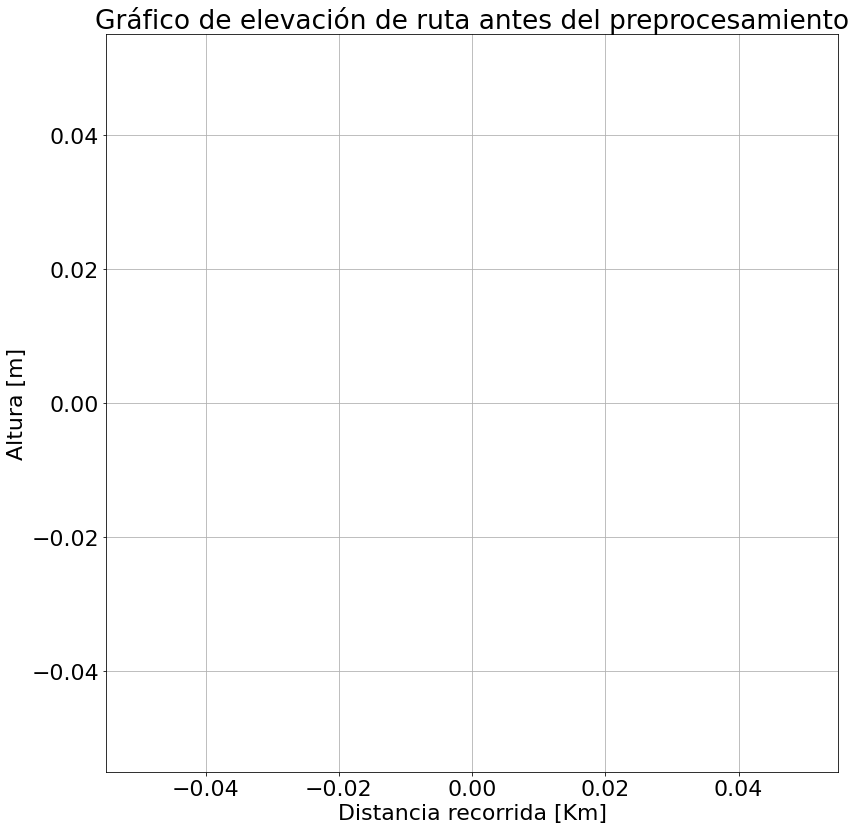

Antes de combinar 177 puntos
Después de combinar 5 secciones


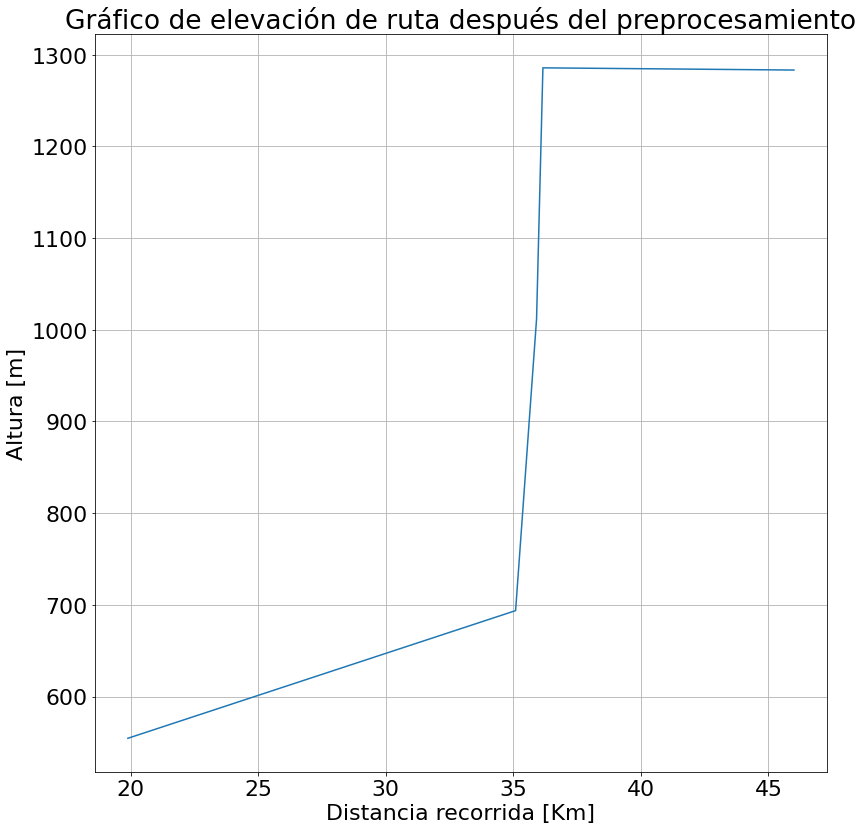

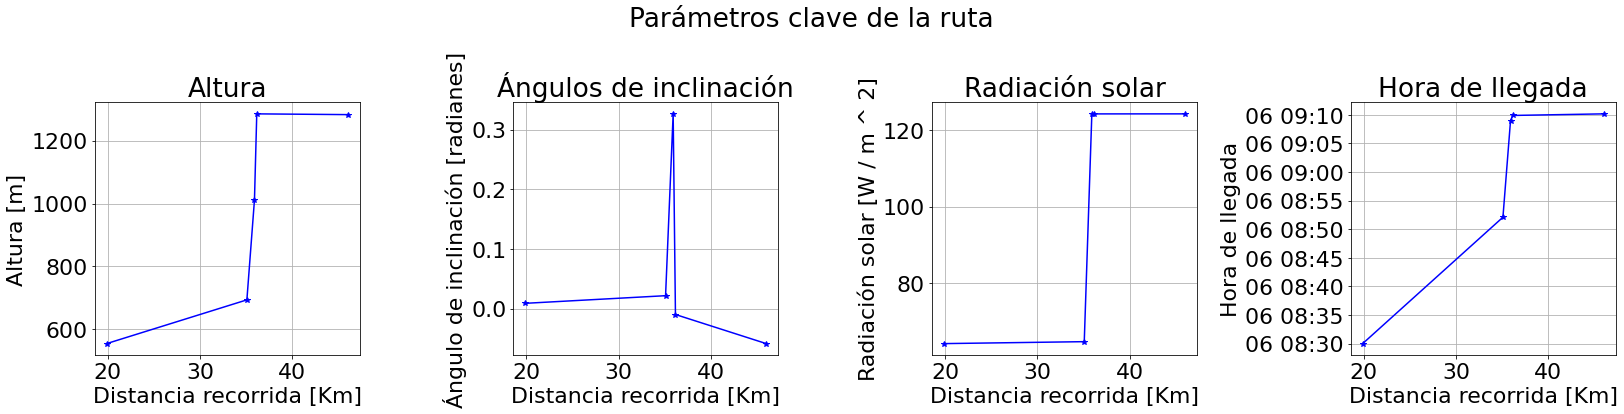

Mejor resultado: 4600.393683974733 Mejor configuración: [6, 10.0, 0]


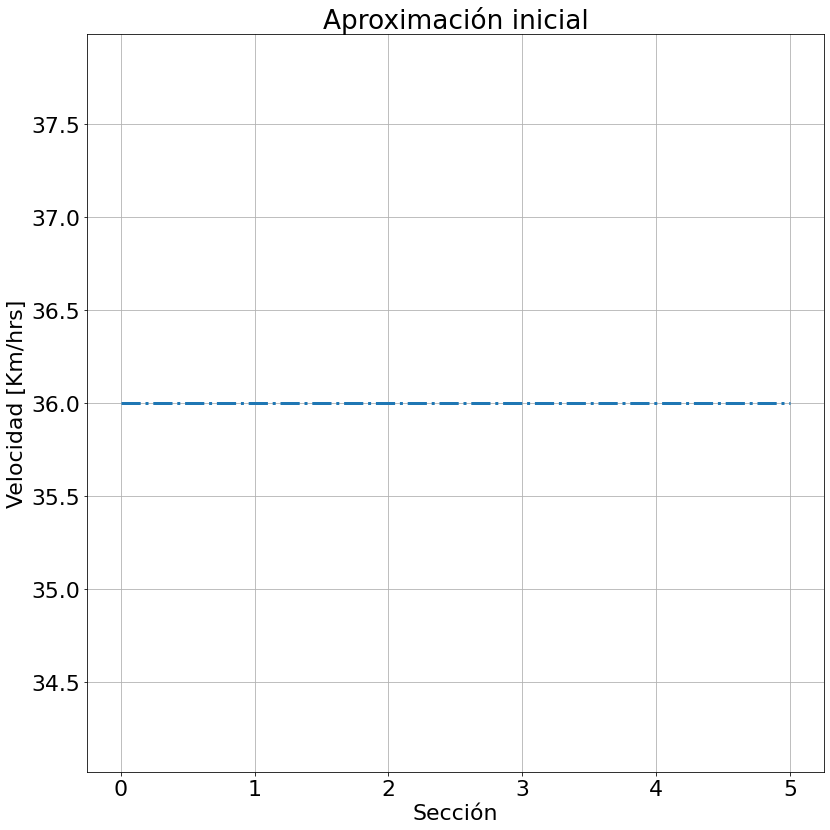

Pérdida inicial: 4600.393683974733 
Penalización inicial: 0.0
Starting minimization
Step: 1 mu: 1
Starting internal minimization
Iteracion: 1 Valor de la función de pérdida: 4347.238
Iteracion: 2 Valor de la función de pérdida: 3025.905
Iteracion: 3 Valor de la función de pérdida: 2376.051
Iteracion: 4 Valor de la función de pérdida: 1836.475
Iteracion: 5 Valor de la función de pérdida: 1754.891
Iteracion: 6 Valor de la función de pérdida: 1747.698
Iteracion: 7 Valor de la función de pérdida: 1740.949
Iteracion: 8 Valor de la función de pérdida: 1735.481
Iteracion: 9 Valor de la función de pérdida: 1732.961
Iteracion: 10 Valor de la función de pérdida: 1730.995
Iteracion: 11 Valor de la función de pérdida: 1730.073
     Optimizacion exitosa? True
     Iteraciones hechas 11
Función Pérdida: 1533.341116367165 
Función Penalización: 196.73207804862662 
MU * Función Penalización 196.73207804862662
Step: 2 mu: 3
Starting internal minimization
Iteracion: 1 Valor de la función de pérdida: 207

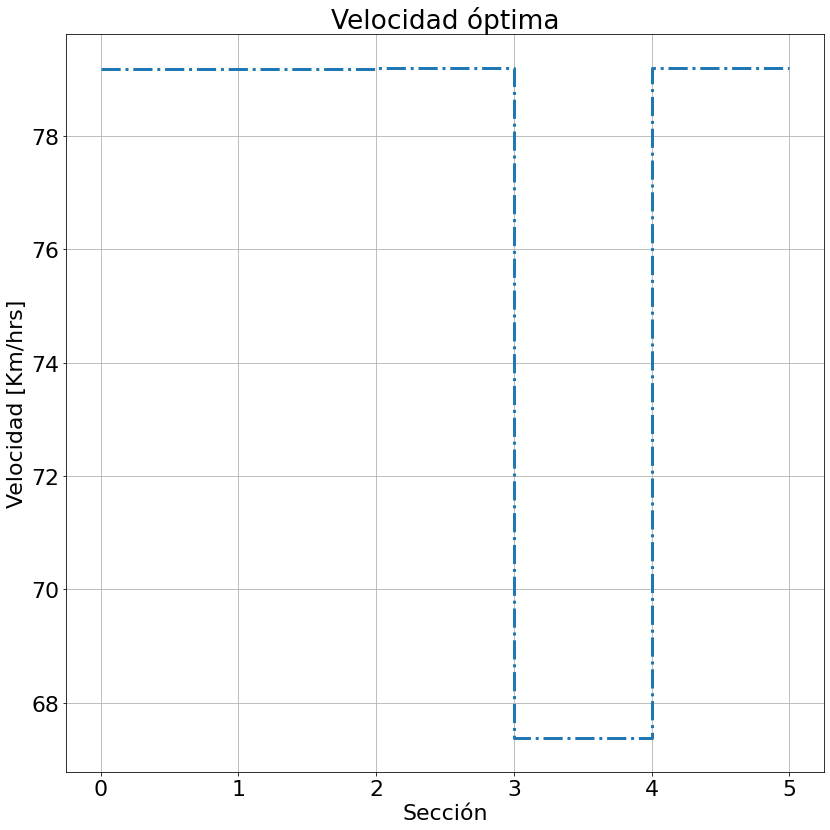

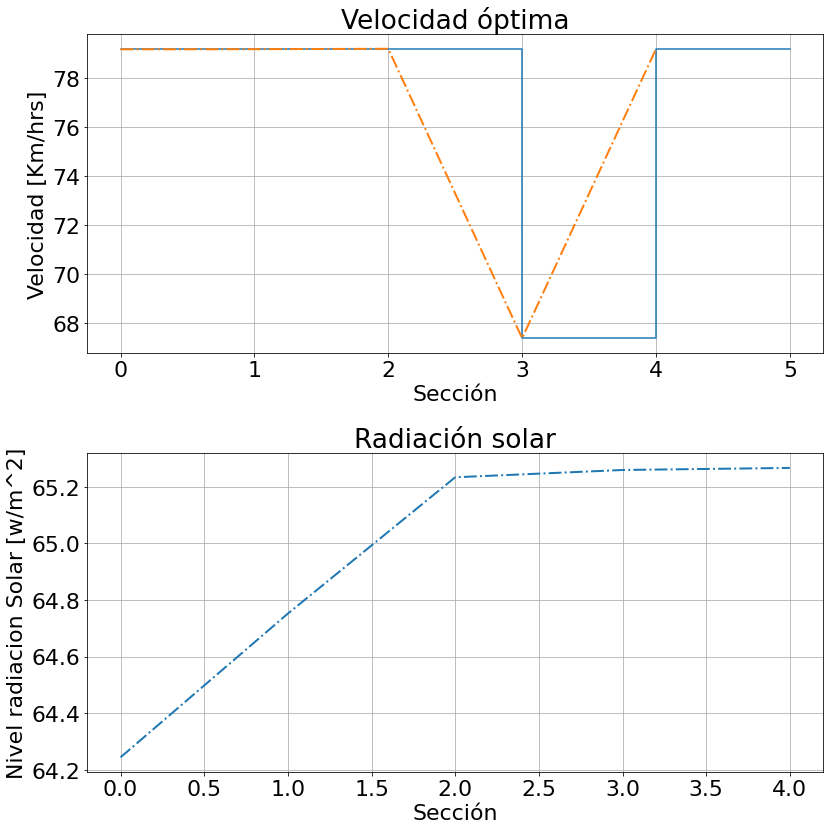

La energía de resultado fue negativa en la sección: 4


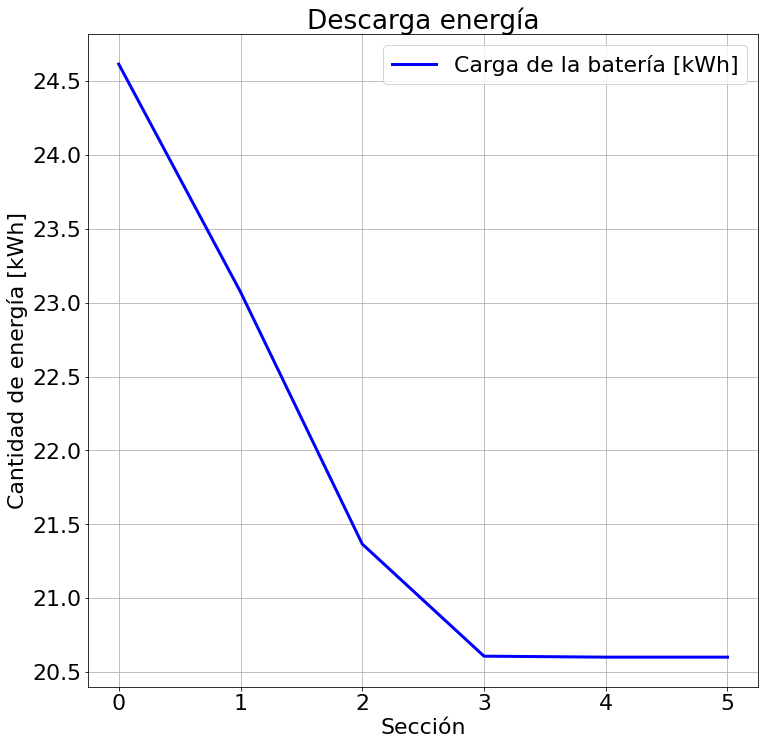

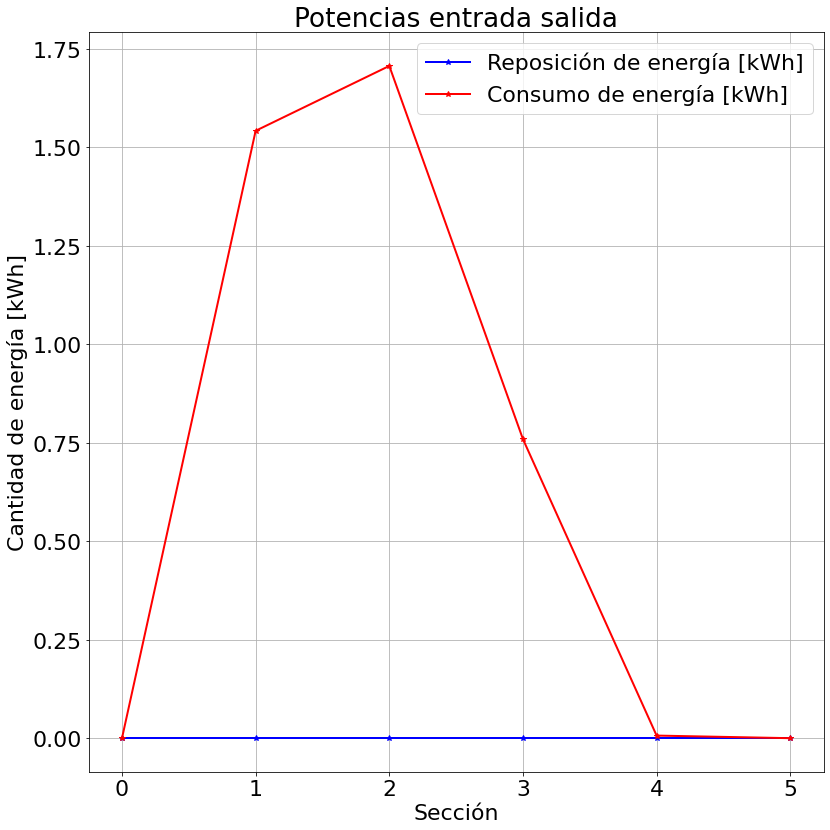

Step: 1 Mejor valor: 
Loss: 2137.8917335916785 Penalización: 0.0 Id: 56
Loss: 2120.359827225243 Penalización: 0.5078672976283589 Id: 62
Loss: 2184.5923292473744 Penalización: 0.0 Id: 55
Step: 2 Mejor valor: 
Loss: 2085.3286028057896 Penalización: 0.05087643954768116 Id: 134
Loss: 2083.5146044342055 Penalización: 0.08024481879258295 Id: 109
Loss: 2115.4881724190436 Penalización: 0.05762650674097468 Id: 68
Step: 3 Mejor valor: 
Loss: 2085.3286028057896 Penalización: 0.05087643954768116 Id: 134
Loss: 2083.5146044342055 Penalización: 0.08024481879258295 Id: 109
Loss: 2088.6095264599253 Penalización: 0.0733350937871922 Id: 151
Step: 4 Mejor valor: 
Loss: 2085.3286028057896 Penalización: 0.05087643954768116 Id: 134
Loss: 2083.5146044342055 Penalización: 0.08024481879258295 Id: 109
Loss: 2077.398901176722 Penalización: 0.1511658965653273 Id: 247
Step: 5 Mejor valor: 
Loss: 2085.3286028057896 Penalización: 0.05087643954768116 Id: 134
Loss: 2083.5146044342055 Penalización: 0.08024481879258295 I

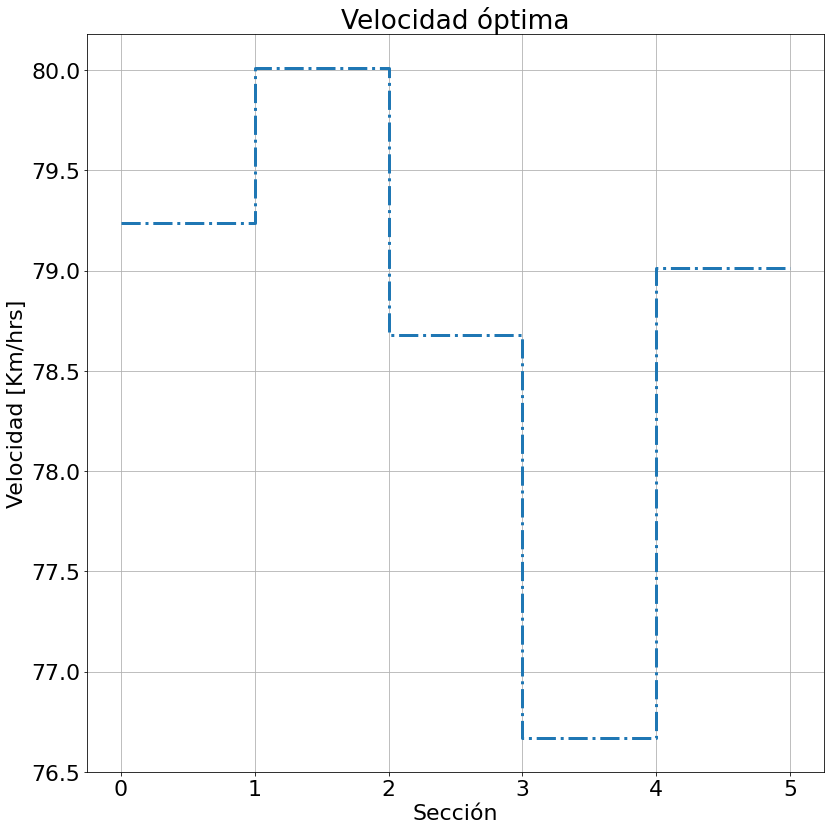

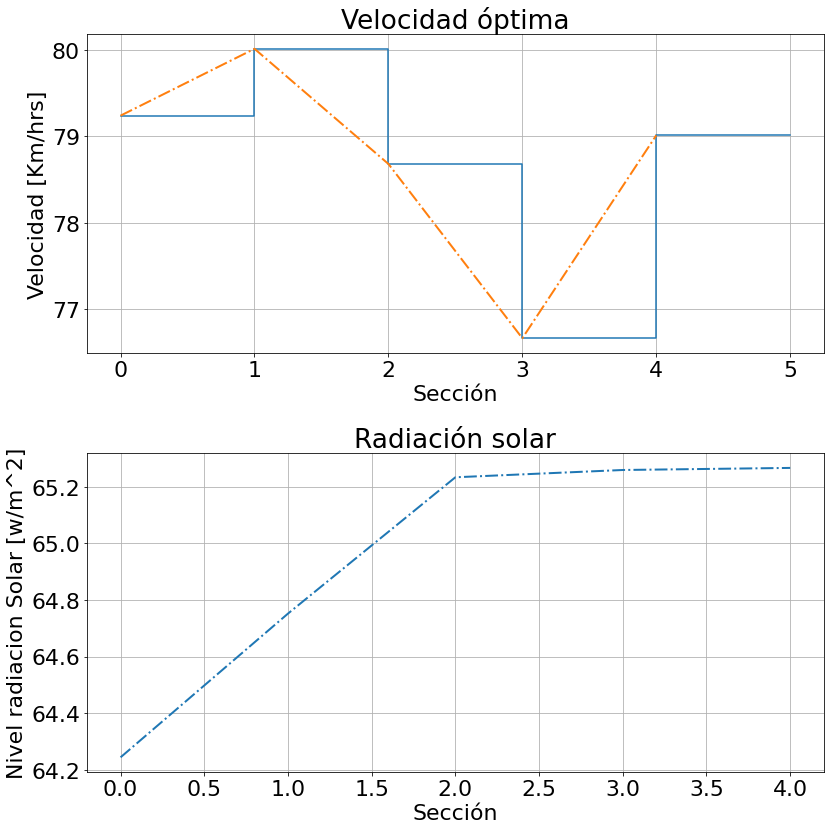

La energía de resultado fue negativa en la sección: 4


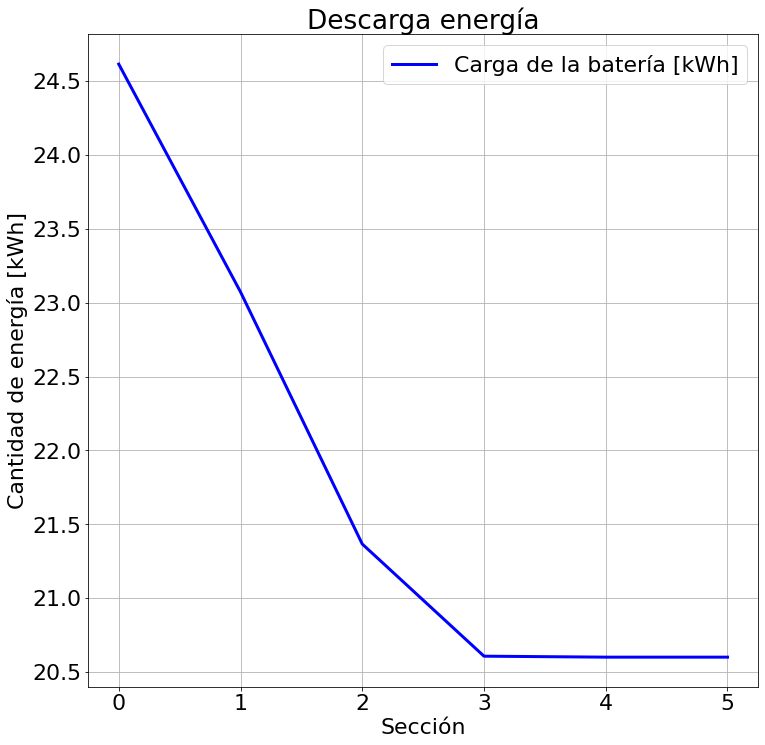

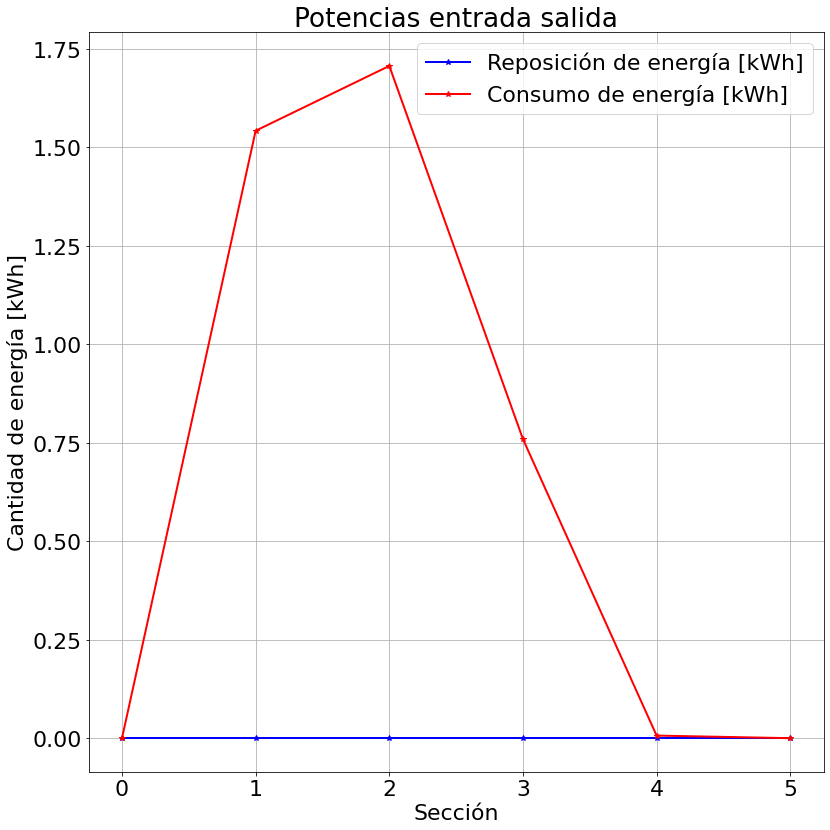

Tiempo de computo total = 51.866363286972046 segundos


In [77]:
font = {"size": 22}
plt.rc("font", **font)
def main():
    """
    Main para resolucion de problema de control optimo
    """
    # Inicialización objeto pista
    # preprocesamiento_columnas_datos("/content/curico-losangeles-sin-filtro.csv")
    pista = Pista(largo_seccion_max=optimizacion["lar_sec_max"],
                  cambio_pendiente_max=optimizacion["camb_pend_max"])
    # carga de datos
    
    pista.cargar_pista_csv("Santiago-LosAndes (1).csvprepos.csv")

    # pista.cargar_pista_csv("27-1-20220506134534-32247-data.csvprepos.csv")
    # preprocesamiento de la altitud
    pista.preprocesar_pista()
    # despliegue de la altitud
    pista.despliegue_altitud_pista("Gráfico de elevación de ruta antes del preprocesamiento")
    # despliegue de la altitud
    pista.combinar_pts_2_seccion()
    # despliegue de la altitud
    pista.despliegue_altitud_pista("Gráfico de elevación de ruta después del preprocesamiento")
    # despliegue de la altitud
    velocidades_inicial = [optimizacion["v0"]] * len(pista.seccion)
    # despliegue de la altitud
    pista.tiempo_llegada(FECHA_HORA_INICIO,
                         RANGO_VELOCIDAD_CONDUCCION,
                         velocidades_inicial)
    # despliegue de la altitud
    pista.calcular_parametros_clima_puro()
    # despliegue de la altitud
    pista.seccion.radiacion_solar = pista.seccion.radiacion_solar #* 1.18
    # despliegue de la altitud
    pista.despliegue_caractersiticas_pista("Parámetros clave de la ruta")
    # despliegue de la altitud
    pista.seccion = pista.seccion[:]
    # Test that optimization is possible
    # velocidades_prueba = [1] * len(pista.seccion)
    # energy_levels_test = calcular_niveles_energia(pista, velocidades_prueba)
    # assert (energy_levels_test[-1] >= 0), "Too little energy to cover the distance!"
    # Find initial approximation
    args = [calcular_funcion_perdida, calcular_penalizacion_total, pista]
    kwargs = dict(low_speed_range=np.linspace(start=2, stop=10, num=40))
    # despliegue de la altitud
    vector_velocidad_base = grid_search(*args, **kwargs)
    # despliegue de la altitud
    despliegue_solucion(vector_velocidad_base,
                        titulo="Aproximación inicial")  # Aproximación inicial
    # despliegue de la altitud
    pista.tiempo_llegada(FECHA_HORA_INICIO,
                         RANGO_VELOCIDAD_CONDUCCION,
                         vector_velocidad_base)
    # Optimize speed
    print("Pérdida inicial:", calcular_funcion_perdida(vector_velocidad_base,
                                                 pista),
          "\nPenalización inicial:",
          calcular_penalizacion_total(vector_velocidad_base,
                                      pista))
    # despliegue de la altitud
    t_0_bfg = time.time()
    velocidades_optimas = metodo_penalizacion(func=calcular_funcion_perdida,
                                              funcion_penalizacion=calcular_penalizacion_total,
                                              x0=vector_velocidad_base,
                                              args=pista,
                                              eps=1,
                                              tol=1e-3,
                                              max_step=30,
                                              show_info=True)
    # despliegue de la altitud
    print("Tiempo de computo método L-BFGS-B = {} segundos".format(time.time() - t_0_bfg))
    # print("Tiempo de cómputo:", , "segundos")
    print("Resultado Optimización", velocidades_optimas)
    # despliegue de la altitud
    print("Pérdida Final:", calcular_funcion_perdida(velocidades_optimas,
                                                  pista),
          "\nPenalización Total:", calcular_penalizacion_total(velocidades_optimas,
                                                          pista))
    print("Tiempo Total viaje:", round(
          calcular_funcion_perdida(velocidades_optimas,
                                   pista) / 3600, 2), "horas")
    # Try to find better solution in point vicinity
    random_change_method(velocidades_optimas,
                         calcular_funcion_perdida,
                         calcular_penalizacion_total, pista,
                         change_koef=1, iter_num=100)
    # Solution visualisation
    despliegue_solucion(velocidades_optimas)
    # Find relation between solar radiation and vehicle speed
    niveles_radiacion_energia = pista.seccion.radiacion_solar
    despliegue_relacion_velocidad_radiacion_solar(velocidades_optimas,
                                                  niveles_radiacion_energia)
    # Save params about model
    model_data = calcular_niveles_energia_full(pista, velocidades_optimas)
    # despliegue de la altitud
    despliegue_niveles_energia(niveles_energia=model_data["niveles"],
                               energia_entradas=model_data["entradas"],
                               energia_salidas=model_data["salidas"],
                               pot_salidas=model_data["pot_salida"],
                               pot_entradas=model_data["pot_entrada"])
    parametros_modelo = model_data["parametros"]
    parametros_modelo.to_csv("Datos/parametros_modelo "
                        + str(datetime.datetime.today().strftime("%Y-%m-%d %H-%M-%S"))
                        + ".csv", sep=";")
    
    t_0_gen = time.time()
    F = genetic_algorithm(calcular_funcion_perdida, calcular_penalizacion_total,
                          pista, speed_range=range(15, (optimizacion["vmax"])),
                          population_size=10, mutation_rate=5, max_epoch=30, 
                          max_epochs_with_similar_result=3,show_info=True)
    print("Tiempo de computo método AG = {} segundos".format(time.time() - t_0_gen))
    print("Rsultados de optimización:", F)
    print("Pérdida final:", calcular_funcion_perdida(F, pista), "\nPenalización Final:", calcular_penalizacion_total(F, pista))
    print("Tiempo total de viaje:", round(calcular_funcion_perdida(F, pista) / 3600, 2), "horas")
    random_change_method(F, 
                        calcular_funcion_perdida,
                        calcular_penalizacion_total,
                        pista,
                        change_koef=1, iter_num=100)
    # Solution visualisation
    despliegue_solucion(F)
    niveles_radiacion_energia = pista.seccion.radiacion_solar
    # draw_speed_solar_radiation_relation(F, solar_radiation_levels)
    despliegue_relacion_velocidad_radiacion_solar(F, niveles_radiacion_energia)
    model_data = calcular_niveles_energia_full(pista, F)
    despliegue_niveles_energia(niveles_energia=model_data["niveles"],
                               energia_entradas=model_data["entradas"],
                               energia_salidas=model_data["salidas"],
                               pot_salidas=model_data["pot_salida"],
                               pot_entradas=model_data["pot_entrada"])
    parametros_modelo1 = model_data["parametros"]
    parametros_modelo1.to_csv("Datos/parametros_modelo1 "
                        + str(datetime.datetime.today().strftime("%Y-%m-%d %H-%M-%S"))
                        + ".csv", sep=";")
                              #  pot_entradas=model_data["pot_entrada"])
    # draw_energy_levels(energy_levels=model_data["levels"], energy_incomes=model_data["incomes"],
    #                                       energy_outcomes=model_data["outcomes"])


if __name__ == "__main__":
    t_0 = time.time()
    main()
    print("Tiempo de computo total = {} segundos".format(time.time() - t_0))

In [ ]:
# pista = Pista(largo_seccion_max=optimizacion['lar_sec_max'],
#                   cambio_pendiente_max=optimizacion['camb_pend_max'])
#     # carga de datos
# pista.cargar_pista_csv('/content/Santiago-LosAndes (1).csvprepos.csv')

In [ ]:
# genec = genetic_algorithm(calcular_funcion_perdida, 
#                           calcular_penalizacion_total, pista,
#                           speed_range=range(15, 20), population_size=10,
#                           mutation_rate=5, max_epoch=30,
#                           max_epochs_with_similar_result=3,
#                           show_info=False)

In [ ]:

# D = multiple_start(compute_loss_func, compute_total_penalty,
#                    pista, func_type=func_type,
#                    init_points_num=5, show_info=True)

In [ ]:
    # # despliegue de la altitud
    # print('Resultado Optimización', velocidades_optimas)
    # # despliegue de la altitud
    # print('Pérdida Final:', calcular_funcion_perdida(velocidades_optimas,
    #                                               pista),
    #       "\nPenalización Total:", calcular_penalizacion_total(velocidades_optimas,
    #                                                       pista))
    # print('Tiempo Total viaje:', round(
    #     calcular_funcion_perdida(velocidades_optimas,
    #                              pista) / 3600, 2), 'hora')
    # # Try to find better solution in point vicinity
    # random_change_method(velocidades_optimas,
    #                      calcular_funcion_perdida,
    #                      calcular_penalizacion_total, pista,
    #                      change_koef=1, iter_num=100)
    # # Solution visualisation
    # despliegue_solucion(velocidades_optimas)
    # # Find relation between solar radiation and vehicle speed
    # niveles_radiacion_energia = pista.seccion.radiacion_solar
    # despliegue_relacion_velocidad_radiacion_solar(velocidades_optimas,
    #                                               niveles_radiacion_energia)
    # # Save params about model

In [ ]:
# genec

In [ ]:
# gg = multiple_start(calcular_funcion_perdida, 
#                     calcular_penalizacion_total, pista,
#                     init_points_num=5, show_info=True)